<a href="https://colab.research.google.com/github/callmemark/Correlation-of-Night-Air-Temperature-and-light-pollution-in-major-cities-in-the-Philippines/blob/PreTest/Thesis_Proc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Correlation of Night Air Temperature and light pollution in major cities in the Philippines </h1>
</br></br></br>


> Fernandez, Jaron Rix
</br>
Velmonte, Mark john A.



<br>
<br>
<br>

---








<h1>Preperation 1: Install Libraries</h1>

> Install neccesary libraries

In [ ]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install --upgrade pip --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install ipywidgets --quiet

# Install other libraries
!pip install splot --quiet
!pip install -U mgwr --quiet

#!pip freeze

<h1>Preperation 2: Import Libraries</h1>

> after installation we procced to import the libraries

In [2]:
#import libraries

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from google.colab import drive
from os import path, getcwd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

<h1> Preperation 3: Moun Drive </h1>

> To access data from google drive, We need to give permission to mount the drive and gain access to folders and files

In [ ]:
#mount the google drive used
from google.colab import drive
drive.mount('/content/drive')

<h1>Preperation 4: File Reference </h1>

> Create a dictionary to use for file path reference and for process automation

In [5]:
GPKG_DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/GPKG_FILES/"


gpkg_files_dict = {
    "Manila_City" : "Manila_City.gpkg",
    "Taguig_City" : "Taguig_City.gpkg",
    "Pasig_City" : "Pasig_City.gpkg",
    "Paranaque_City" : "Paranaque_City.gpkg",
    "Makati_City" : "Makati_City.gpkg",
    "LasPinas_City" : "LasPinas_City.gpkg",
    "Muntinlupa_City" : "Muntinlupa_City.gpkg",
    "Pasay_City" : "Pasay_City.gpkg",
    "Malabon_City" : "Malabon_City.gpkg",
    "Butuan_City" : "Butuan_City.gpkg",
    "grouped_study_area" : "grouped_study_area.gpkg"  
}



DATASET_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/climactic_factor_dataset_v2/"

CITY_NAME= [
    "manila_city",
    "valenzuela_city",
    "taguig_city",
    "pasig_city",
    "pasay_city",
    "paranaque_city",
    "muntinlupa_city",
    "malabon_city",
    "makati_city",
    "laspinas_city"
]


LIGHTPOL_DIRECTORY = "/content/drive/My Drive/COLLEGE_THESIS_FOLDER/DataSet/Light_pol_data/"

y_ext = ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]
lpol_cname = [
  "manila_lpol_data_",
  "taguig_lpol_data_",
  "pasig_lpol_data_",
  "paranaque_lpol_data_",
  "makati_lpol_data_",
  "laspinas_lpol_data_",
  "muntinlupa_lpol_data_",
  "pasay_lpol_data_",
  "malabon_lpol_data_",
  "valenzuela_lpol_data_",
]

<h1>Preperation 5: Create helper function and class</h1>

> Create function and classes methods that will be use repeatedly

In [6]:
# Helper functions and Classes
def get_gpk_fpath(city_name_arg = str):
  try:
    return GPKG_DATASET_DIRECTORY + gpkg_files_dict[city_name_arg]
  except:
    raise Exception("error in get_gpk_fpath func | No City in dataset")
    

def get_file_path(city_name_arg):
  _fstr = DATASET_DIRECTORY + city_name_arg + ".csv"
  return _fstr


In [95]:
class MMREG_PROCS():
  def __init__(self, x_arg, y_arg, title_arg = "Data Analysis"):
    self.x_sample = x_arg
    self.y_sample = y_arg
    self.proc_title = title_arg
  

  def standard_proc(self, _show_plot_arg = True):
    self.scikit_train_proc(show_plot_arg = _show_plot_arg)
    self.disp_res_header()
    self.scikit_proc()
    self.statmod_proc()
    self.calc_pct()

  
  def disp_res_header(self):
    print(("===" * 26), "'\n")
    print(self.proc_title.center(26, "="))


  def calc_pct(self):
    x_axis_pct_chage = pd.DataFrame(self.x_sample).pct_change()
    y_axis_pct_chage = pd.DataFrame(self.y_sample).pct_change()

    print(("===" * 26), "'\n")
    print("PCT: \n", x_axis_pct_chage, y_axis_pct_chage)
    print(("===" * 26), "'\n")
    return [x_axis_pct_chage, y_axis_pct_chage]


  def scikit_train_proc(self, test_size_arg = 0.3, random_state_arg = 0, show_plot_arg = True):
    self.lr_model = LinearRegression()
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x_sample, self.y_sample, test_size = test_size_arg, random_state = random_state_arg)
    self.lr_model.fit(self.X_train, self.y_train)
    self.y_pred = self.lr_model.predict(self.X_train)
    
    if show_plot_arg:
      plt.scatter(self.y_train, self.y_pred, color = "black")
      sns.regplot(x = self.y_train, y = self.y_pred , ci=None, color ='orange')

      plt.style.use('seaborn-pastel')
      plt.ylabel("Factors")
      plt.xlabel("N.Time Temp")
      plt.title(self.proc_title)

      plt.show()
    
    return [self.y_train, self.y_pred]


  def scikit_proc(self):
    regr = linear_model.LinearRegression()
    fitted_model = regr.fit(self.x_sample, self.y_sample)
    print(("===" * 26), "'\n")
    print("SCIKIT LEARN RESULT: ")
    print("Intercept: ", fitted_model.intercept_)
    print('Coefficients: ', fitted_model.coef_)
    print(("===" * 26), "'\n")

    return fitted_model


  def statmod_proc(self):
    _x = sm.add_constant(self.x_sample)
 
    model = sm.OLS(self.y_sample, _x).fit()
    predictions = model.predict(_x) 
    
    reg_ressult = model.summary()
    print(reg_ressult)

    return reg_ressult
  

  def vif(self, print_output = True):
    _result = [variance_inflation_factor(self.x_sample.values, i) for i in range(len(self.x_sample.columns))]
    return _result

<h1>Procedures</h1>

> 1. get light pollution annual average per city
<br>
> 2. filter data to obtains night time information (7pm-4am)
<br>
> 3. Calculate the annaul average of every parameter for every city
<br>
> 4. Create new Data frame for every city obtaining the night time annual average value of parameters
<br>
> 5. Combine all the processed data into a single dataset 

<h1>Procedure 1</h1>

> 1. get light pollution annual average per city



In [ ]:
dict_keys = ['Manila_City', 'Taguig_City', 'Pasig_City', 'Paranaque_City', 'Makati_City', 'Las Pinas_City', 'Muntinlupa_City', 'Pasay_City', 'Malabon_City', 'Valenzuela_City']
lpol_data_dict = {}

for _index in range(len(lpol_cname)):
  _avg_init_list = []
  for _year in y_ext:
    fname = lpol_cname[_index] + _year

    avg_val = np.average(np.array(pd.read_csv(LIGHTPOL_DIRECTORY + fname + ".csv", skiprows = 1))) # open csv || skip headder >> convert to numpy >> get avg
    _avg_init_list.append(avg_val)

  lpol_data_dict[dict_keys[_index]] = _avg_init_list
  print(dict_keys[_index], ": Data Process complete")

lpol_data_df = pd.DataFrame(lpol_data_dict)

<h1>Procedures 2</h1>

> 2. filter data to obtains night time information (7pm-4am)


In [ ]:
# create a empty dictionary
nt_city_df_dict = {}

# loop through the list
for city in CITY_NAME:
  dict_key = city
  city_df = pd.read_csv(get_file_path(city), skiprows = 13)
  
  # filter data from t-19 to t-04
  print("Proc city: ", city)
  nightime_data = city_df.loc[(city_df["HR"] <= 4) | (city_df["HR"] >= 19)]

  # create new dictinary item and add new data
  nt_city_df_dict[dict_key] = nightime_data


print(nt_city_df_dict.keys())

<h1>Procedures 3</h1>


> 3. Calculate the annaul average of every parameter for every city


In [ ]:
# year 2011-2020
year_range = [i for i in range(2012, 2022)]
# climactic factors
df_params = ["PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR", "Lat", "Long"]

# initialize empty dictionary
cities_yparam_avg_val = {}

# loop through the cities 
for city_name in CITY_NAME: # or CITY_NAME_2010_2010 || Same value
  city_dict_key = city_name
  cities_yparam_avg_val[city_dict_key] = {}
  
  # loop through the climatic factors
  for param_name in df_params:
    # initialize new empty list every iteration
    initial_param_avg_list = []

    # loop through the year
    for _year in year_range:
      # get the average value of the current iterated climatic factor

      tgt_y = nt_city_df_dict[city_dict_key].loc[nt_city_df_dict[city_dict_key]["YEAR"] == _year][param_name]
      param_avg_val = np.average(np.array(tgt_y))

      # appent to empty list
      initial_param_avg_list.append(param_avg_val)

      # add new dictionary key and its value
      cities_yparam_avg_val[city_dict_key][param_name] = np.array(initial_param_avg_list)


print(cities_yparam_avg_val.keys())

<h1>Procedures 4</h1>

> 4. Create new Data frame for every city obtaining the night time annual average value of parameters
 

In [11]:
paranaque_df = pd.DataFrame(cities_yparam_avg_val["paranaque_city"])
valenzuela_df = pd.DataFrame(cities_yparam_avg_val["valenzuela_city"])
taguig_df = pd.DataFrame(cities_yparam_avg_val["taguig_city"])
makati_df = pd.DataFrame(cities_yparam_avg_val["makati_city"])
muntinlupa_df = pd.DataFrame(cities_yparam_avg_val["muntinlupa_city"])
manila_df = pd.DataFrame(cities_yparam_avg_val["manila_city"])
pasig_df = pd.DataFrame(cities_yparam_avg_val["pasig_city"])
las_Pinas_df = pd.DataFrame(cities_yparam_avg_val["laspinas_city"])
pasay_df = pd.DataFrame(cities_yparam_avg_val["pasay_city"])
malabon_df = pd.DataFrame(cities_yparam_avg_val["malabon_city"])

<h1>Procedures 5</h1>

> 5. Combine all the processed data into a single dataset 

In [12]:
# (long, lat)
paranque_coord = [(nt_city_df_dict["paranaque_city"]["Long"].iloc[0], nt_city_df_dict["paranaque_city"]["Lat"].iloc[0])] * 10
valenzuela_coord = [(nt_city_df_dict["valenzuela_city"]["Long"].iloc[0], nt_city_df_dict["valenzuela_city"]["Lat"].iloc[0])] * 10
taguig_coord = [(nt_city_df_dict["taguig_city"]["Long"].iloc[0], nt_city_df_dict["taguig_city"]["Lat"].iloc[0])] * 10
makati_coord = [(nt_city_df_dict["makati_city"]["Long"].iloc[0], nt_city_df_dict["makati_city"]["Lat"].iloc[0])] * 10
muntinlupa_coord = [(nt_city_df_dict["muntinlupa_city"]["Long"].iloc[0], nt_city_df_dict["muntinlupa_city"]["Lat"].iloc[0])] * 10
manila_coord = [(nt_city_df_dict["manila_city"]["Long"].iloc[0], nt_city_df_dict["manila_city"]["Lat"].iloc[0])] * 10
pasig_coord = [(nt_city_df_dict["pasig_city"]["Long"].iloc[0], nt_city_df_dict["pasig_city"]["Lat"].iloc[0])] * 10
pasay_coord = [(nt_city_df_dict["pasay_city"]["Long"].iloc[0], nt_city_df_dict["pasay_city"]["Lat"].iloc[0])] * 10
malabon_coord = [(nt_city_df_dict["malabon_city"]["Long"].iloc[0], nt_city_df_dict["malabon_city"]["Lat"].iloc[0])] * 10
laspinas_coord = [(nt_city_df_dict["laspinas_city"]["Long"].iloc[0], nt_city_df_dict["laspinas_city"]["Lat"].iloc[0])] * 10


g_coords = paranque_coord + valenzuela_coord + taguig_coord + makati_coord + muntinlupa_coord + manila_coord + pasig_coord + pasay_coord + malabon_coord + laspinas_coord
cities_df = [
    paranaque_df, 
    valenzuela_df, 
    taguig_df, 
    makati_df, 
    muntinlupa_df, 
    manila_df, 
    pasig_df, 
    pasay_df, 
    malabon_df, 
    las_Pinas_df]


lpol_data = [
    lpol_data_df["Paranaque_City"],
    lpol_data_df["Manila_City"],
    lpol_data_df["Taguig_City"],
    lpol_data_df["Pasig_City"],
    lpol_data_df["Las Pinas_City"],
    lpol_data_df["Muntinlupa_City"],
    lpol_data_df["Pasay_City"],
    lpol_data_df["Malabon_City"],
    lpol_data_df["Valenzuela_City"],
    lpol_data_df["Makati_City"]
]

NCR_geopckg = get_gpk_fpath("grouped_study_area")
NCR_geopckg = gpd.read_file(NCR_geopckg)

lpol_df_data = pd.concat(lpol_data)
cities_df = pd.concat(cities_df)


cities_df["LongLat"] = g_coords
cities_df["lpol_avg"] = lpol_df_data

In [ ]:
#cities_df.to_csv(DATASET_DIRECTORY + 'grouped_samnples_pgkg_set.csv')

<h1>DATA PROCESSING</h1>

<h1>Multiple Linear Regression</h1>

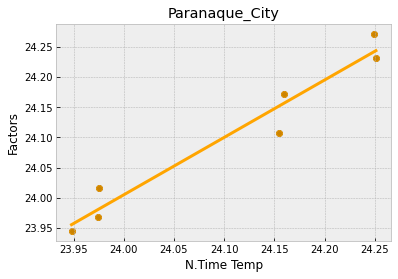

============================================================================== '

======Paranaque_City======
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -100.11097778735521
Coefficients:  [ 1.146005    0.70135924 -0.71750512 -0.23077234  0.00690669]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     13.86
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0123
Time:                        05:46:36   Log-Likelihood:                 18.450
No. Observations:                  10   AIC:                            -24.90
Df Residuals:                       4   BIC

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [149]:
_x_val = paranaque_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Paranaque_City"]
_y_val = paranaque_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Paranaque_City").standard_proc()

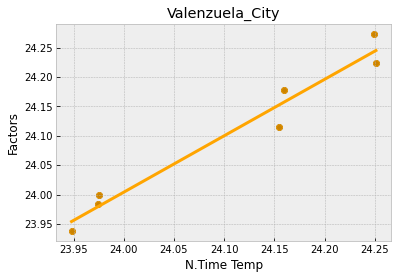

============================================================================== '

=====Valenzuela_City======
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -93.40289070926057
Coefficients:  [ 1.08426489  0.68931795 -0.91469365 -0.29071803  0.02017882]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     19.04
Date:                Fri, 30 Sep 2022   Prob (F-statistic):            0.00683
Time:                        05:46:35   Log-Likelihood:                 19.962
No. Observations:                  10   AIC:                            -27.92
Df Residuals:                       4   BIC:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [148]:
_x_val = valenzuela_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Valenzuela_City"]
_y_val = valenzuela_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Valenzuela_City").standard_proc()

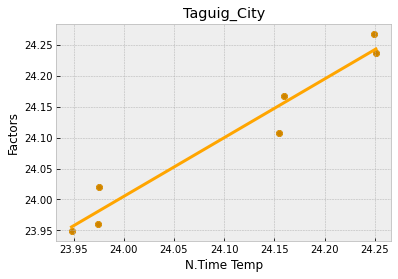

============================================================================== '

=======Taguig_City========
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -97.40721945029216
Coefficients:  [ 1.12073248  0.6881778  -0.71849206 -0.25162987  0.01064409]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     13.91
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0122
Time:                        05:46:35   Log-Likelihood:                 18.465
No. Observations:                  10   AIC:                            -24.93
Df Residuals:                       4   BIC:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [147]:
_x_val = taguig_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Taguig_City"]
_y_val = taguig_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Taguig_City").standard_proc()

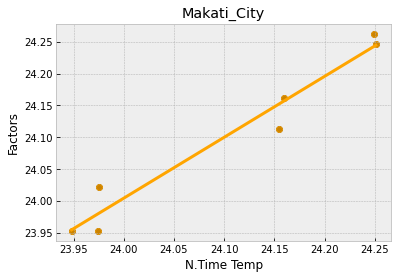

============================================================================== '

=======Makati_City========
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -148.18033758124815
Coefficients:  [ 1.62683251  0.77980168 -0.71611504 -0.35844287 -0.0113356 ]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     18.07
Date:                Fri, 30 Sep 2022   Prob (F-statistic):            0.00753
Time:                        05:46:33   Log-Likelihood:                 19.711
No. Observations:                  10   AIC:                            -27.42
Df Residuals:                       4   BIC

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [146]:
_x_val = makati_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Makati_City"]
_y_val = makati_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Makati_City").standard_proc()

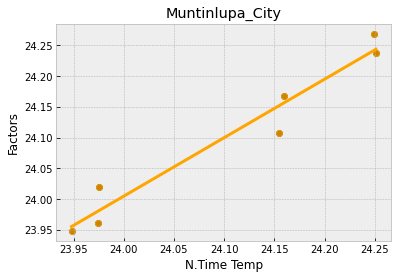

============================================================================== '

=====Muntinlupa_City======
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -161.7007658059731
Coefficients:  [ 1.75225292  0.78941992 -0.44889877 -0.24761657 -0.01438271]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     11.89
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0163
Time:                        05:46:31   Log-Likelihood:                 17.729
No. Observations:                  10   AIC:                            -23.46
Df Residuals:                       4   BIC:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [145]:
_x_val = muntinlupa_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Muntinlupa_City"]
_y_val = muntinlupa_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Muntinlupa_City").standard_proc()

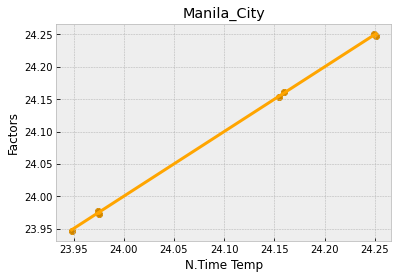

============================================================================== '

=======Manila_City========
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -136.21841477806257
Coefficients:  [ 1.49967938  0.74356187 -0.5314185  -0.20005221  0.0036962 ]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     11.39
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0176
Time:                        05:46:30   Log-Likelihood:                 17.526
No. Observations:                  10   AIC:                            -23.05
Df Residuals:                       4   BIC

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [143]:
_x_val = manila_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Manila_City"]
_y_val = manila_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Manila_City").standard_proc()

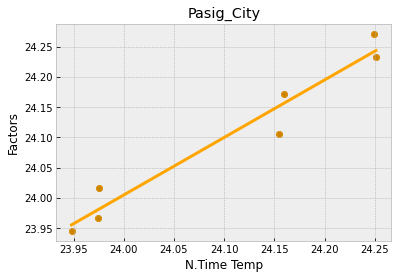

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


============================================================================== '

========Pasig_City========
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -115.48683165746783
Coefficients:  [ 1.29699124  0.71411318 -0.65205723 -0.21324124  0.00756015]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     12.47
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0150
Time:                        05:46:30   Log-Likelihood:                 17.952
No. Observations:                  10   AIC:                            -23.90
Df Residuals:                       4   BIC

In [144]:
_x_val = pasig_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Pasig_City"]
_y_val = pasig_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Pasig_City").standard_proc()

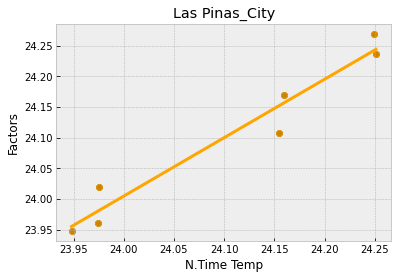

============================================================================== '

======Las Pinas_City======
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -121.53105784490194
Coefficients:  [ 1.35503991  0.73169856 -0.63569524 -0.2465969   0.01338437]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     12.61
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0147
Time:                        05:46:28   Log-Likelihood:                 18.004
No. Observations:                  10   AIC:                            -24.01
Df Residuals:                       4   BIC

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [142]:
_x_val = las_Pinas_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Las Pinas_City"]
_y_val = las_Pinas_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Las Pinas_City").standard_proc()

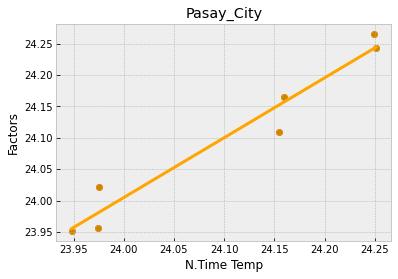

============================================================================== '

========Pasay_City========
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -144.20958349529906
Coefficients:  [ 1.57874697  0.7652473  -0.49766138 -0.23108724 -0.00191244]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     11.41
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0176
Time:                        05:46:26   Log-Likelihood:                 17.537
No. Observations:                  10   AIC:                            -23.07
Df Residuals:                       4   BIC

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [141]:
_x_val = pasay_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Pasay_City"]
_y_val = pasay_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Pasay_City").standard_proc()

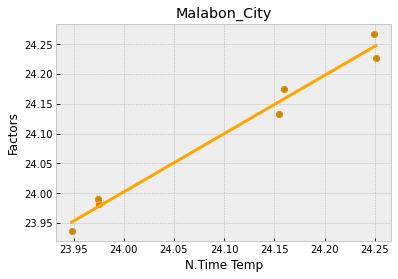

============================================================================== '

=======Malabon_City=======
============================================================================== '

SCIKIT LEARN RESULT: 
Intercept:  -105.6126819889536
Coefficients:  [ 1.20689927  0.687824   -0.83969259 -0.30256568  0.01592971]
============================================================================== '

                            OLS Regression Results                            
Dep. Variable:                    T2M   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     20.45
Date:                Fri, 30 Sep 2022   Prob (F-statistic):            0.00597
Time:                        05:46:24   Log-Likelihood:                 20.305
No. Observations:                  10   AIC:                            -28.61
Df Residuals:                       4   BIC:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [140]:
_x_val = malabon_df.drop(["Lat", "Long", "T2M"], axis = 1)
_x_val["lpol"] = lpol_data_dict["Malabon_City"]
_y_val = malabon_df["T2M"]

MMREG_PROCS(_x_val, _y_val, "Malabon_City").standard_proc()

<h1>Multiscale Linear Regression</h1>

In [112]:
#g_y = cities_df['lpol_avg'].values.reshape((-1,1)) #T2M
#g_X = cities_df[['QV2M', "PS", "WS10M", "PRECTOTCORR", "T2M"]].values

g_y = cities_df['T2M'].values.reshape((-1,1)) #T2M
cities_df["lpol"] = cities_df['lpol_avg']
g_X = cities_df[['QV2M', "PS", "WS10M", "PRECTOTCORR", "lpol_avg"]].values
g_coords = list(g_coords)

#g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
#g_y = g_y.reshape((-1,1))
#g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [113]:
g_X[np.isnan(g_X)] = 0
g_y[np.isnan(g_y)] = 0

In [114]:
gwr_selector = Sel_BW(g_coords, g_y, g_X, kernel = "gaussian", fixed = False, spherical=True) 
gwr_bw = gwr_selector.search(bw_min = 2)
gwr_bw

91.0

In [115]:
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [116]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 100
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.178
Log-likelihood:                                                     174.765
AIC:                                                               -337.530
AICc:                                                              -334.312
BIC:                                                               -432.708
R2:                                                                   0.934
Adj. R2:                                                              0.930

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [117]:
gwr_filtered_t = gwr_results.filter_tvals()

In [130]:
def show_plot_by_res_index(res_arg, var_ind_title):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
  ax.set_title("Variable " + var_ind_title + "  " + 'GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=12)

  cmap = plt.cm.seismic

  gwr_min = res_arg.min()
  gwr_max = res_arg.max()
  vmin = np.min([gwr_min])
  vmax = np.max([gwr_max])

  #If all values are negative use the negative half of the colormap
  if (vmin < 0) & (vmax < 0):
      cmap = truncate_colormap(cmap, 0.0, 0.5)
  #If all values are positive use the positive half of the colormap
  elif (vmin > 0) & (vmax > 0):
      cmap = truncate_colormap(cmap, 0.5, 1.0)
  #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
  else:
      cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
  NCR_geopckg.plot(cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':1})


  fig.tight_layout()    
  sm._A = []
  cbar = fig.colorbar(sm)
  cbar.ax.tick_params(labelsize=12) 
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.style.use('seaborn-pastel')
  plt.show()

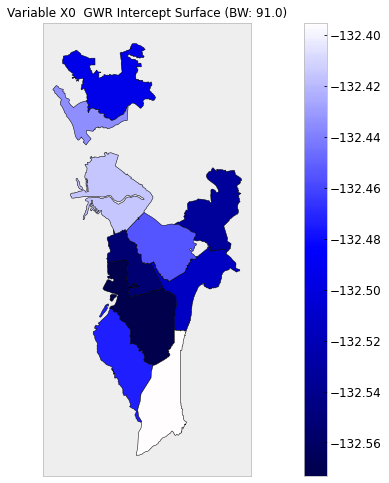

In [131]:
show_plot_by_res_index(gwr_results.params[:,0], "X0")

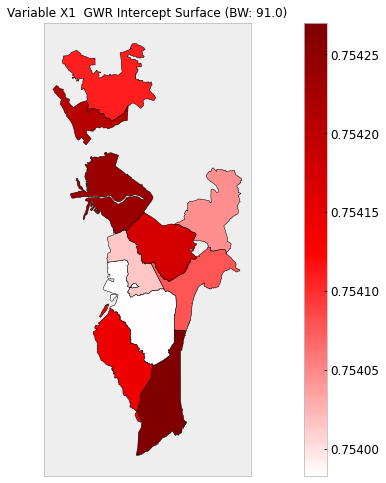

In [133]:
show_plot_by_res_index(gwr_results.params[:,1], "X1")

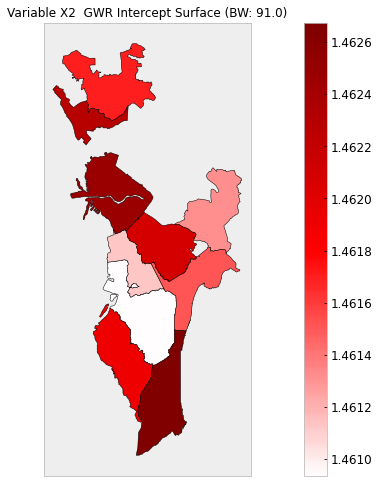

In [135]:
show_plot_by_res_index(gwr_results.params[:,2], "X2")

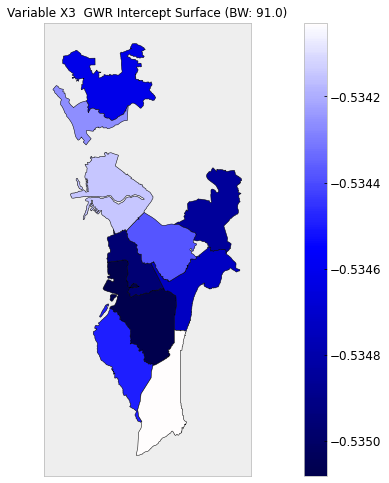

In [137]:
show_plot_by_res_index(gwr_results.params[:,3], "X3")

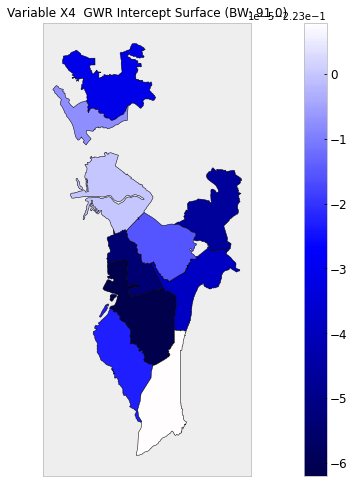

In [138]:
show_plot_by_res_index(gwr_results.params[:,4], "X4")

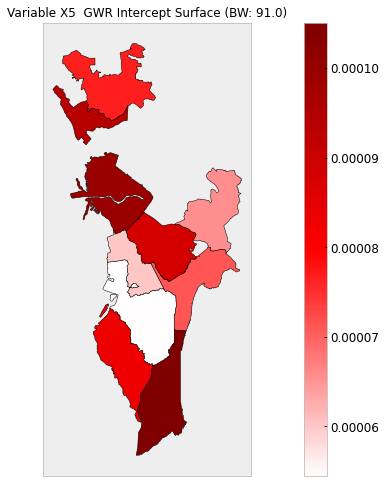

In [139]:
show_plot_by_res_index(gwr_results.params[:,5], "X5")